In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()

Setting up params

 >> Context(max_t=3.0, dt=0.1, n_instances=30, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

Here - decoder: x -> sin(x)

In [271]:
def gen_xy_sin_to_f(n_samples=500, n_t=100, f=None, dt=0.01):
    # x_train = array (unique_samples, xs_over_t, sin(xs))
    # y_train = array (unique_samples, xs_over_t, sin(xs + dx))
    max_t = n_t * dt
    min_f = utils.min_f(max_t)
    max_f = utils.max_f(dt)
    print('allowed min max f', min_f, max_f)
    min_f = 9
    max_f = 9
    if f is None:
        fs = np.random.random(n_samples) * (max_f - min_f) + min_f
    else:
        fs = np.repeat(f, n_samples)
        
    phases = np.random.random(n_samples) * 2*np.pi
    timesteps = np.arange(n_t) * dt
    x_train = []
    y_train = []    
    for i, phase in enumerate(phases):
        # x: beginning of cycle
        f = fs[i]
        d_phase = n_t * dt * f
        x_train.append(sin_(n_t, f, phase))
        # y: continuation of cycle        
        y_train.append(sin_(n_t, f, phase + d_phase))
    
    x_train = np.stack(x_train)
    x_train = x_train.reshape(n_samples, n_t, 1) 
    y_train = np.stack(y_train)
    y_train = y_train.reshape(n_samples, n_t, 1)
    return x_train, y_train
    
def sin_(n, f, phase=0, dt=0.01):
    phase = 0
    ts = np.arange(n) * dt
    return (np.sin(2*np.pi * f * ts + phase * 2 * np.pi) + 1) * 0.5

def categorize_array(array, n_categories=10):
    # transform an array of values in range [0,1] to an array of one hot vectors
    # array :: (samples, timesteps, value)
    # ouput :: (samples, timesteps, value-array)
    enc = OneHotEncoder(categorical_features='all', dtype=np.float,
       handle_unknown='error', n_values=n_categories, sparse=False)
    range_array = np.arange(n_categories).reshape(n_categories, 1)
    enc.fit(range_array)
    
    # iterate, for every value: transform(value) -> one hot vector
    dims = list(array.shape)
    dims[-1] = n_categories
    new = np.empty(dims)
    # encode using batches of 1 sample (thus, x timesteps) 
    it = np.nditer(array[:,0,0], flags=['multi_index'])
    while not it.finished:
        index_sample = it.multi_index
        values = array[index_sample]
        encoded = enc.transform(values * (n_categories-1))
        new[index_sample] = encoded
        it.iternext()
    return new

def value_to_vector(value, n_categories=3, default=1):
    # sklearn.preprocessing.OneHotEncoder
    # 0 <= value < 1
    vector = np.zeros(n_categories)
    index = round(value * (n_categories-1)) # value / 1 / n;    n-1 to fix indexing
    vector[index] = default
    return vector
    
def vector_to_number(vector):
    n = vector.shape[0]
    # estimate the breakpoints (a la quantiles, percentiles)
    breakpoints = [ x * 1.0/n for x in range(n)]
    index = vector.argmax()
    return breakpoints[index]

In [272]:
a = np.arange(8).reshape(2,4,1) / 8
new = categorize_array(a)
new.shape

(2, 4, 10)

In [270]:
to_vector(ar, 3)

array([[1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0.]])

In [199]:
from sklearn.preprocessing import OneHotEncoder
n_categories = 5
enc = OneHotEncoder(categorical_features='all', dtype=np.float,
       handle_unknown='error', n_values=n_categories, sparse=False)
# enc.fit_transform([[2],[1]])
range_array = np.arange(5).reshape(5,1)
enc.fit(range_array)
enc.transform(range_array)
a = np.arange(9).reshape(9,1).clip(0,4)
a
enc.transform(a)
list(a.shape) + [2]
# enc.n_values
# enc.feature_indices_
# np.array([0, 2, 5, 9])
# enc.transform([0, 1, 1]).toarray()

[9, 1, 2]

In [124]:
np.arange(2).reshape(1,2).reshape(1,-1)

array([[0, 1]])

In [106]:
n = 100
f = None
# f = 3
dt = 0.01
x_train, y_train = gen_xy_sin_to_f(n, f=f, dt=dt) # encoder_input_data
y_train = x_train[:,:-1,:]
z_train = x_train[:,1:,:]
x_train = y_train

# y_train = x_train # decoder_input_data
# z_train = y_train.copy() # decoder_target_data
# z_train[:,:-1,:] = z_train[:,1:,:] # shift all timesteps +1
x_test, y_test = gen_xy_sin_to_f(10, f=f, dt=dt)
print(x_train.shape, y_train.shape, z_train.shape)

NameError: name 'utils' is not defined

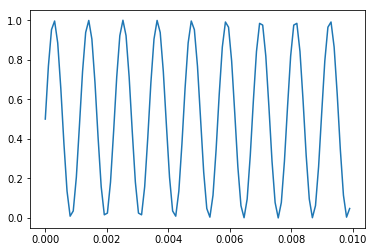

In [7]:
n4 = x_train.shape[1]
plt.plot(np.arange(n4) / n4 * dt, x_train[0])

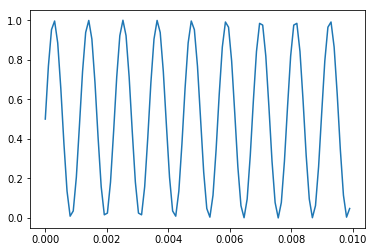

In [8]:
plt.plot(np.arange(n4) / n4 * dt, y_train[0])

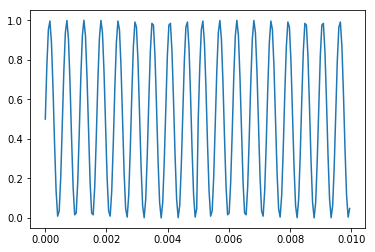

In [9]:
full = np.concatenate([x_train[0],y_train[0]])
n5 = full.shape[0]
plt.plot(np.arange(n5) / n5 * dt, full)

In [10]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 10
input_shape

(99, 1)

In [11]:
output_shape

(99, 1)

In [12]:
# def model(input_shape, output_shape):
"""
encoded, states = lstm(input())
decoded
while predicting (for every timestep): 
    decoded <- lstm(input() ++ states) # ++ decoded?
"""

# input shape = (None, None, 1)
# thus: unfixed n samples, unfixed n timesteps, 1 float value
encoder_input = Input(shape=(None,1))
hidden_size = 32
# discard the direct output of the encoder_lstm
_, state_h, state_c = LSTM(hidden_size, return_state=True, bias_initializer='random_normal')(encoder_input)
encoder_states = [state_h, state_c]

decoder_input = Input(shape=(None, 1))
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, bias_initializer='random_normal')
decoder_output, _, _ = decoder_lstm(decoder_input, initial_state=encoder_states)
print('dims decoder_output =', keras.backend.int_shape(decoder_output))


w = np.prod(output_shape)
# w = 10
print('w =',w)
decoder_dense = Dense(w, activation='relu')
decoder_output = decoder_dense(decoder_output)
decoder_dense = Dense(1, activation='softmax')
decoder_output = decoder_dense(decoder_output)
print('dims decoder_dense =', keras.backend.int_shape(decoder_output))
# decoder_reshape = Reshape(output_shape)
# decoder_output = decoder_reshape(decoder_output)
# print('dims decoder_reshape =', keras.backend.int_shape(decoder_output))


#     model = Model(inputs=input_layer, outputs=x)
model = Model([encoder_input, decoder_input], decoder_output)
#     return model

# model = model(input_shape, output_shape)
model.summary()

dims decoder_output = (None, None, 32)
w = 99
dims decoder_dense = (None, None, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 32), (None,  4352        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 32), ( 4352        input_2[0][0]                    
                          

In [13]:
# encoder.summary()
# decoder.summary()

In [14]:
metrics = ['accuracy','mse','binary_crossentropy'] # sparse_categorical_accuracy
loss = 'mae'# binary_crossentropy categorical_crossentropy sparse_categorical_crossentropy
optimizer = 'rmsprop' # adam adadelta rmsprop nadam
# keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae'])#, metrics=metrics)

In [15]:
batch_size = 32
# n epochs = n iterations over all the training data
epochs = 30

In [16]:
callbacks = []
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]
vs = 1/6
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
model.fit([x_train,y_train], z_train, epochs=epochs, batch_size=batch_size,
          validation_split=vs, callbacks=callbacks)

Train on 83 samples, validate on 17 samples
Epoch 1/30
83/83 [==============================] - 1s 10ms/step - loss: 0.5000 - mean_squared_error: 0.3763 - mean_absolute_error: 0.5000 - val_loss: 0.5000 - val_mean_squared_error: 0.3763 - val_mean_absolute_error: 0.5000
Epoch 2/30
83/83 [==============================] - 0s 4ms/step - loss: 0.5000 - mean_squared_error: 0.3763 - mean_absolute_error: 0.5000 - val_loss: 0.5000 - val_mean_squared_error: 0.3763 - val_mean_absolute_error: 0.5000
Epoch 3/30
83/83 [==============================] - 0s 4ms/step - loss: 0.5000 - mean_squared_error: 0.3763 - mean_absolute_error: 0.5000 - val_loss: 0.5000 - val_mean_squared_error: 0.3763 - val_mean_absolute_error: 0.5000
Epoch 4/30
83/83 [==============================] - 0s 4ms/step - loss: 0.5000 - mean_squared_error: 0.3763 - mean_absolute_error: 0.5000 - val_loss: 0.5000 - val_mean_squared_error: 0.3763 - val_mean_absolute_error: 0.5000
Epoch 5/30
83/83 [==============================] - 0s 4ms/

# Inferencing

In [17]:
def decode_sequence(input_seq, encoder):
    # Encode the input as state vectors.
    states_value = encoder.predict(input_seq)

    # Generate empty target sequence of length 1.
    num_decoder_tokens = 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 1] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

# decode_sequence

In [18]:
x_test.shape

(10, 100, 1)

In [19]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [20]:
results = model.predict([x_test,x_test])
results.shape

(10, 100, 1)

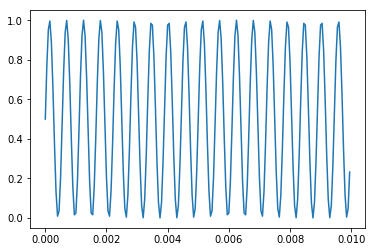

In [21]:
# the 'true' results
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

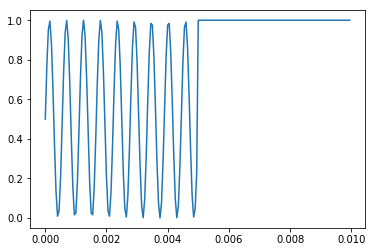

In [22]:
# predicted results
i = 0
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

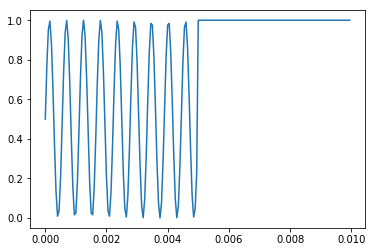

In [23]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

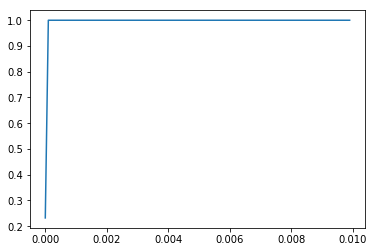

In [24]:
i = 0
selection = 1
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)